In [1]:
#imports
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Normalize
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

#from tqdm import tqdm as tqdm
import torch.optim.lr_scheduler as lr_scheduler

In [2]:
DATA_DIRECTORY = 'E:\CSE465 project\DATASET\Split_Dataset'

print(os.listdir(DATA_DIRECTORY))

['test', 'train', 'val']


In [3]:
TRAIN_DIRECTORY = 'E:/CSE465 project/DATASET/Split_Dataset/train'
VAL_DIRECTORY = 'E:/CSE465 project/DATASET/Split_Dataset/val'
TEST_DIRECTORY = 'E:/CSE465 project/DATASET/Split_Dataset/test'

In [4]:
print(os.listdir(TRAIN_DIRECTORY))

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '5', '6', '7', '8', '9']


In [5]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# Hyper-parameters 
num_epochs = 15
batch_size = 100
learning_rate = 0.01

In [7]:
train_data = ImageFolder(TRAIN_DIRECTORY, transform=ToTensor())
val_data = ImageFolder(VAL_DIRECTORY, transform=ToTensor())
test_data = ImageFolder(TEST_DIRECTORY, transform=ToTensor())

In [8]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

24712
3072
3132


In [9]:
train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_dl = DataLoader(val_data, batch_size*2, num_workers=4, pin_memory=True)
val_dl = DataLoader(test_data, batch_size*2,shuffle=True, num_workers=4, pin_memory=True)

In [10]:
#load pretrained model
model = torchvision.models.vgg16_bn(pretrained = True)

In [11]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [12]:
for param in model.parameters():
    param.requires_grad = True

model.avgpool = Identity()
model.classifier = nn.Sequential(nn.Linear(in_features=512*3*3, out_features=256, bias=True),
                                 nn.BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(in_features=256, out_features=128, bias=True),
                                 nn.BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True),
                                 nn.ReLU(inplace=True))


model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [13]:
from torch.nn import Parameter
import math

In [14]:
def l2_norm(input, axis = 1):
    norm = torch.norm(input, 2, axis, True)
    output = torch.div(input, norm)

    return output

In [15]:
# your code goes here
class Arcface(nn.Module):
    def __init__(self, embedding_size=128, classnum=45,  s=2, m=0.5):
        super(Arcface, self).__init__()
        self.classnum = classnum
        self.kernel = Parameter(torch.FloatTensor(embedding_size,classnum), requires_grad=True)
        # initial kernel
        self.kernel.data.uniform_(-1, 1).renorm_(2,1,1e-5).mul_(1e5)
        self.m = m # the margin value, default is 0.5
        self.s = s # scalar value default is 64, see normface https://a...content-available-to-author-only...v.org/abs/1704.06369
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
    def forward(self, embbedings, label):
        # weights norm
        nB = len(embbedings)
        kernel_norm = l2_norm(self.kernel,axis=0)
        # cos(theta) using dot product
        cos_theta = torch.mm(embbedings,kernel_norm)
        cos_theta = cos_theta.clamp(-1,1) # for numerical stability
        #Sqrt(1 - cos^2(theta))
        sin_theta = torch.sqrt(torch.clamp((1.0 - torch.pow(cos_theta, 2)),1e-9,1))
        #cos(theta+m) = cos(theta)*cos(m) - sin(theta)*sin(m)
        cos_theta_m = (cos_theta * self.cos_m - sin_theta * self.sin_m)
        output = cos_theta * 1.0 # a little bit hacky way to prevent in_place operation on cos_theta
        idx_ = torch.arange(0, nB, dtype=torch.long)
        output[idx_, label] = cos_theta_m[idx_, label] 
        output *= self.s #scale up in order to make softmax work, first introduced in normface
        return output

In [16]:
metric_fc = Arcface().to(device)
criterion = torch.nn.CrossEntropyLoss()

# optimzer nn
optimizer_nn = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)

# optimzer arcface
optimzer_arcface = torch.optim.SGD(metric_fc.parameters(), lr=0.01)

Epoch [1/15], Step [194/248], Loss: 2.2974
Epoch [2/15], Step [194/248], Loss: 1.1914
Epoch [3/15], Step [194/248], Loss: 0.8734
Epoch [4/15], Step [194/248], Loss: 0.8333
Epoch [5/15], Step [194/248], Loss: 0.7679
Epoch [6/15], Step [194/248], Loss: 0.7420
Epoch [7/15], Step [194/248], Loss: 0.7355
Epoch [8/15], Step [194/248], Loss: 0.7511
Epoch [9/15], Step [194/248], Loss: 0.7376
Epoch [10/15], Step [194/248], Loss: 0.7339
Epoch [11/15], Step [194/248], Loss: 0.7311
Epoch [12/15], Step [194/248], Loss: 0.7349
Epoch [13/15], Step [194/248], Loss: 0.7276
Epoch [14/15], Step [194/248], Loss: 0.7364
Epoch [15/15], Step [194/248], Loss: 0.7372
Finished Training


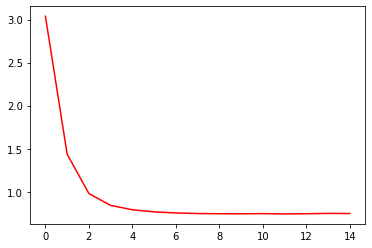

In [17]:
n_total_steps = len(train_dl)
loss_vals = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_dl):
        images = images.to(device)
        labels = labels.to(device)
        
        # set opt
        optimizer_nn.zero_grad()
        optimzer_arcface.zero_grad()

        # Forward pass
        outputs = model(images.float())
        outputs = metric_fc(outputs, labels)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer_nn.step()
        optimzer_arcface.step()
        
        running_loss += loss.item()

        if (i+1) % 194 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            
    epoch_loss = running_loss / len(train_dl)
    loss_vals.append(epoch_loss)

print('Finished Training')
plt.plot(np.array(loss_vals), 'r')

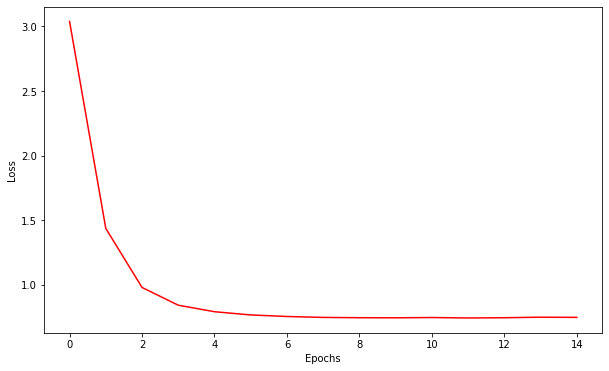

In [32]:
plt.figure(figsize=(10,6))
plt.plot(np.array(loss_vals), 'r')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('test.jpg')

In [19]:
def test(model, metric_fc, criterion, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            features3d = model(data.float())
            
            output = metric_fc(features3d, labels)
            test_loss += criterion(output, labels)
            # test_loss += centerLoss(output, target, device, features3d)
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nResult: Average loss: {}, Accuracy: {}/{} ({}%)\n'.format(
        str(test_loss), str(correct), str(len(test_loader.dataset)),
        str(100. * correct / len(test_loader.dataset))))

In [20]:
test(model, metric_fc, criterion, device, train_dl)


Result: Average loss: tensor(0.0074, device='cuda:0'), Accuracy: 24677/24712 (99.85836840401424%)



In [21]:
test(model, metric_fc, criterion, device, test_dl)


Result: Average loss: tensor(0.0040, device='cuda:0'), Accuracy: 3053/3072 (99.38151041666667%)



In [22]:
test(model, metric_fc, criterion, device, val_dl)


Result: Average loss: tensor(0.0039, device='cuda:0'), Accuracy: 3099/3132 (98.9463601532567%)

